<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/Gaussian_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GNB + PCA + HYPERPARAMETER TUNING

Datasets loaded successfully.

Checking for missing values in training data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in training data.

Checking for missing values in testing data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in testing data.

Training data shape: (60000, 784)
Testing data shape: (10000, 784)

PCA transformed training data shape: (60000, 50)
PCA transformed testing data shape: (10000, 50)
Total explained variance by 50 components: 82.46%

Best hyperparameters: {'var_smoothing': 0.0023101297000831626}
Best cross-validation Accuracy: 86.97%

Test Accuracy with tuned GaussianNB: 87.84%

Confusion Matrix:
[[ 921    0    6    5    0   33   11    3    1    0]
 [   0 1075   21    3    0   11    6    2   16    1]
 [  16    1  865   35   18    8   12   20   52    5]
 [

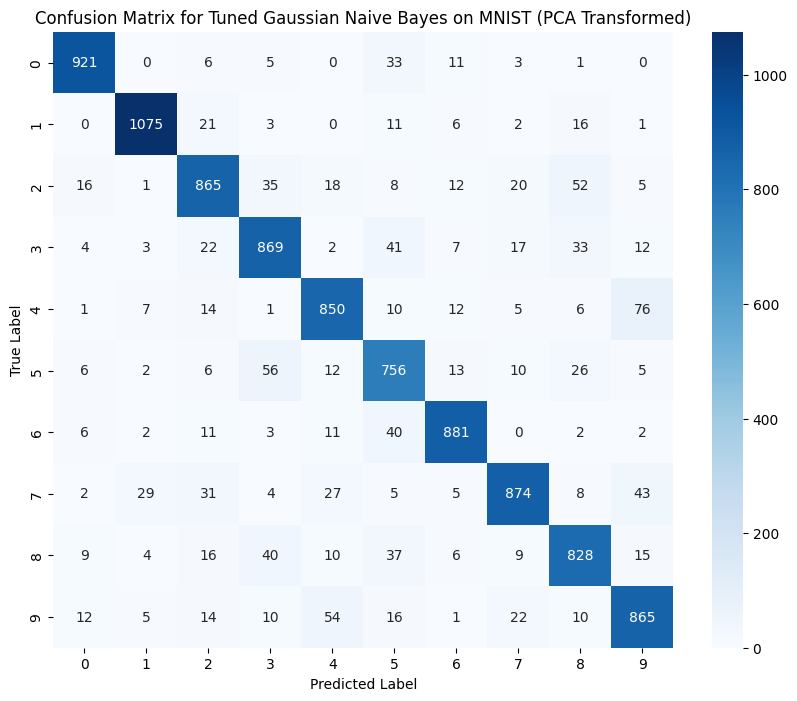

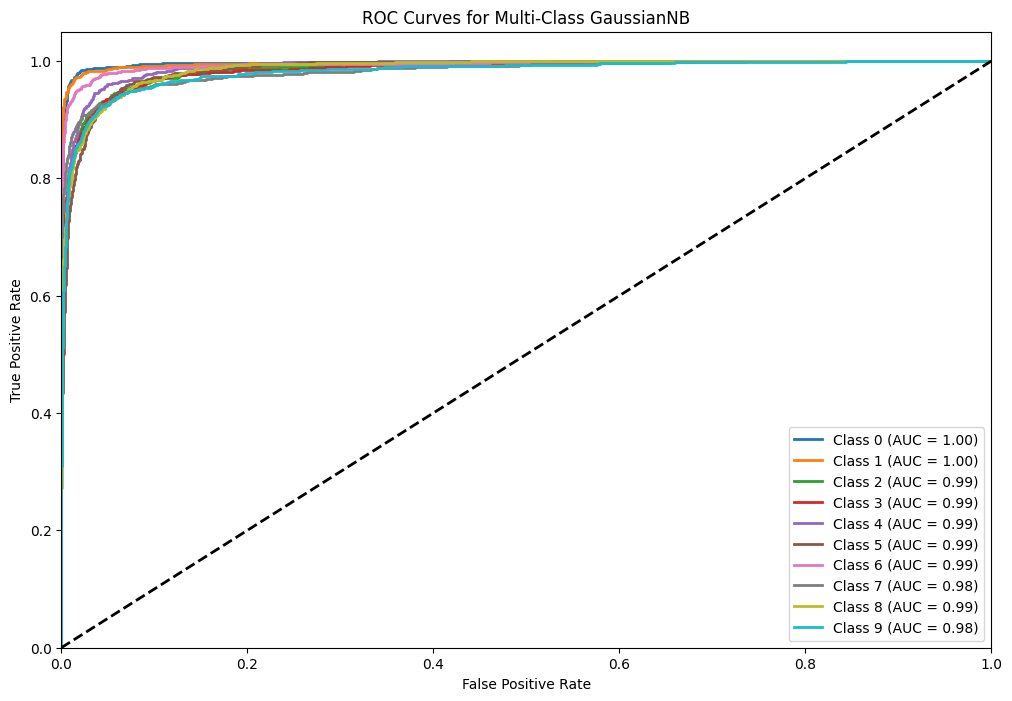

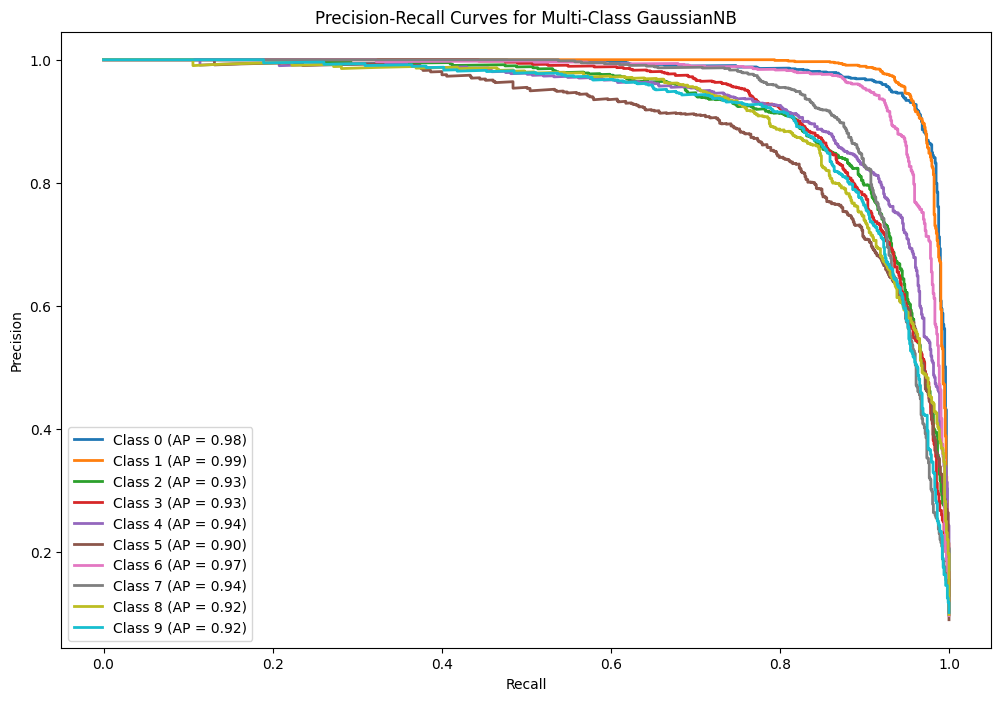

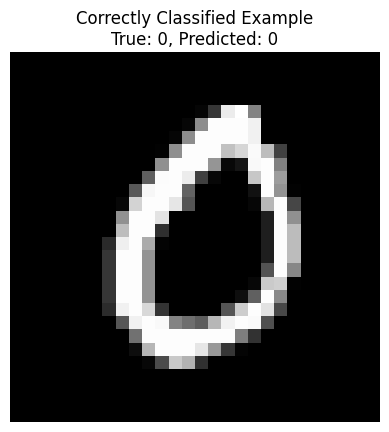

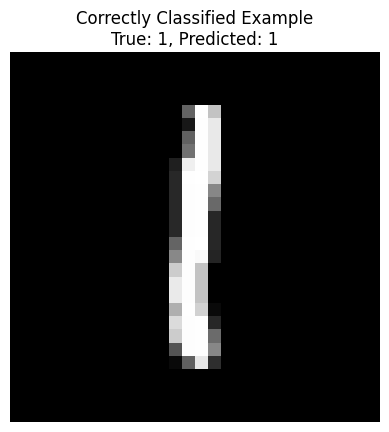

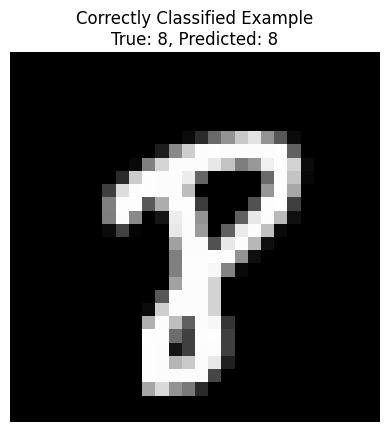

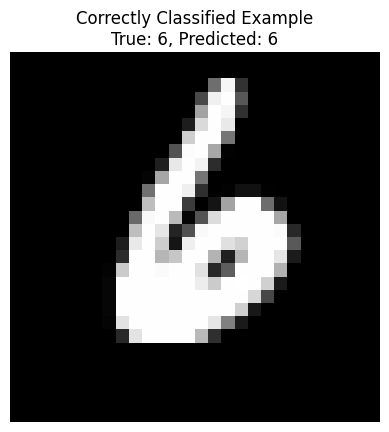

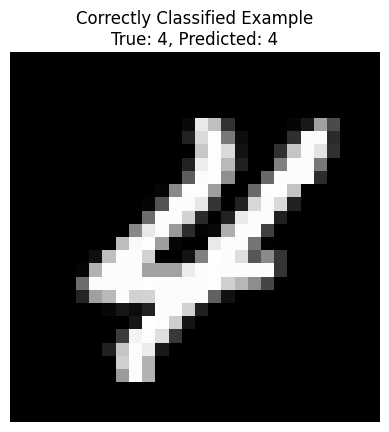

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
import random
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Functions for Data Loading and Preprocessing
def load_data(train_path, test_path):
    try:
        train_data = pd.read_csv(train_path, header=None)
        test_data = pd.read_csv(test_path, header=None)
        print("Datasets loaded successfully.")
        return train_data, test_data
    except FileNotFoundError as e:
        print(f"Error: CSV files not found. Ensure '{train_path}' and '{test_path}' exist in your working directory.")
        raise e

def check_and_impute(data, name="Data"):
    print(f"\nChecking for missing values in {name}:")
    missing_counts = data.isnull().sum()
    print(missing_counts)
    if data.isnull().values.any():
        data.fillna(data.mean(), inplace=True)
        print(f"Missing values in {name} filled with column means.")
    else:
        print(f"No missing values found in {name}.")
    return data

# Load and Preprocess the Data
train_data, test_data = load_data("mnist_train.csv", "mnist_test.csv")
train_data = check_and_impute(train_data, "training data")
test_data = check_and_impute(test_data, "testing data")

# The first column is assumed to be the label.
label_column = train_data.columns[0]
X_train = train_data.drop(label_column, axis=1)
y_train = train_data[label_column]
X_test = test_data.drop(label_column, axis=1)
y_test = test_data[label_column]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Normalize pixel values (from 0-255 to 0-1)
scaling_factor = 255.0
X_train_norm = X_train / scaling_factor
X_test_norm = X_test / scaling_factor

# Apply PCA to reduce dimensionality
pca_components = 50
pca = PCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

print("\nPCA transformed training data shape:", X_train_pca.shape)
print("PCA transformed testing data shape:", X_test_pca.shape)
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Total explained variance by {} components: {:.2f}%".format(pca_components, explained_variance * 100))

# Hyperparameter Tuning with GridSearchCV for GaussianNB
param_grid = {"var_smoothing": np.logspace(-10, -1, 100)}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Use the best estimator from grid search for further predictions
best_gnb = grid_search.best_estimator_

# Evaluate the Tuned Model on the Test Set
y_pred = best_gnb.predict(X_test_pca)

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy with tuned GaussianNB: {:.2f}%".format(accuracy * 100))

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Additional evaluation metrics (macro-averaged)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Macro-Average Precision: {:.2f}".format(precision_macro))
print("Macro-Average Recall: {:.2f}".format(recall_macro))
print("Macro-Average F1 Score: {:.2f}".format(f1_macro))

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for Tuned Gaussian Naive Bayes on MNIST (PCA Transformed)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Compute predicted probabilities for each class using the tuned model
y_prob = best_gnb.predict_proba(X_test_pca)
n_classes = 10

# Binarize the true labels for multi-class evaluation (one-hot encoding)
y_test_bin = np.eye(n_classes)[y_test]

# Initialize dictionaries to store metrics for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

# Compute ROC curve and Precision-Recall curve for each class
for i in range(n_classes):
    # ROC curve and ROC AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Precision-Recall curve and Average Precision
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class GaussianNB')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class GaussianNB')
plt.legend(loc="lower left")
plt.show()

# Identify correctly classified indices
correct_indices = np.where(y_pred == y_test)[0]

def display_images(indices, title, n_samples=5):
    if len(indices) > 0:
        sample_indices = random.sample(list(indices), min(n_samples, len(indices)))
        for idx in sample_indices:
            # Reshape the normalized test image to 28x28 for visualization
            image = X_test_norm.iloc[idx].values.reshape(28, 28)
            plt.imshow(image, cmap='gray')
            plt.title(f"{title}\nTrue: {y_test.iloc[idx]}, Predicted: {y_pred[idx]}")
            plt.axis('off')
            plt.show()
    else:
        print(f"No {title.lower()} examples found.")

# Display 5 correctly classified examples
display_images(correct_indices, "Correctly Classified Example", n_samples=5)
